In [1]:
import os, shutil

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from PIL import Image

In [2]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [3]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

torch.Size([500, 1]) torch.Size([500, 1])
torch.Size([17, 1]) torch.Size([17, 1])


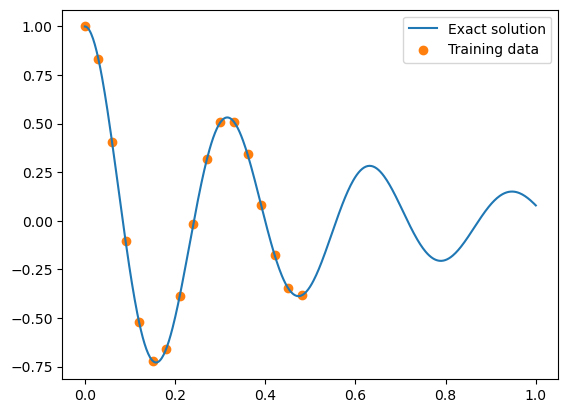

In [4]:
d, w0 = 2, 20

# get the analytical solution over the full domain
x = torch.linspace(0,1,500).view(-1,1)
y = oscillator(d, w0, x).view(-1,1)
print(x.shape, y.shape)

# slice out a small number of points from the LHS of the domain
x_data = x[0:251:15]
y_data = y[0:251:15]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [5]:
class FullyConnected(nn.Module):
    "Defines a fully connected neural network"
    def __init__(self, layer_size, activation=nn.ReLU):
        super().__init__()
        layers = []
        
        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation())            
        
        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )
        
    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            outpt = layer(outpt)
        
        return outpt

In [6]:
def plot_result(x,y,x_data,y_data,yh, i, xp=None):
    "Pretty plot training results"
    plt.figure(figsize=(8,4))
    plt.plot(x,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(x,yh, color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="large")
    plt.setp(l.get_texts(), color="k")
#     plt.xlim(-0.05, 1.05)
#     plt.ylim(-1.1, 1.1)
    plt.text(1.065,0.7,"Training step: %i"%(i+1),fontsize="xx-large",color="k")
    plt.axis("off")


In [7]:
def train_oscillator():

    x_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# sample locations over the problem domain
    mu, k = 2*d, w0**2

#     torch.manual_seed(2022)
    model = FullyConnected([1, 32, 32, 32, 1], activation=nn.Tanh)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
    files = []
    epochs=8000
    losses = dict(dataloss=[], physicsloss=[])
    
    for i in range(epochs):
        optimizer.zero_grad()

        # compute the "data loss"
        yh = model(x_data)
        dataloss = torch.mean((yh-y_data)**2)# use mean squared error

        # compute the "physics loss"
        yhp = model(x_physics)
        dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
        dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
        physics = dx2 + mu*dx + k*yhp# computes the residual of the 1D harmonic oscillator differential equation
        physicsloss = (1e-4)*torch.mean(physics**2)

        # backpropagate joint loss
        loss = dataloss + physicsloss# add two loss terms together
        loss.backward()
        optimizer.step()
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())
        
        # plot the result as training progresses
#         if (i+1) % 10 == 0: 
        if (i+1) % (epochs//5) == 0: 

            yh = model(x).detach()
            xp = x_physics.detach()

            plot_result(x,y,x_data,y_data,yh, i, xp)
            plt.show()
            fig = plt.figure(figsize=(12, 4))
#            xphysics_plot = x_physics.detach().numpy()
            plt.plot(xp, dx.detach().numpy(), label="dx")
            plt.plot(xp, dx2.detach().numpy(), label="dx2")
            plt.plot(xp, -(mu*dx + k*yhp).detach().numpy(), label="physics law")
            plt.legend()
            figs.append(fig)
#            print(dx)
#           print(dx2, '\n',  mu*dx + k*yhp)
            print("data physics loss", dataloss, physicsloss)
#            file = "plots/pinn_%.8i.png"%(i+1)
#            plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
#            files.append(file)

#            if (i+1) % 200 == 0: plt.show()
#            else: plt.close("all")
    return losses

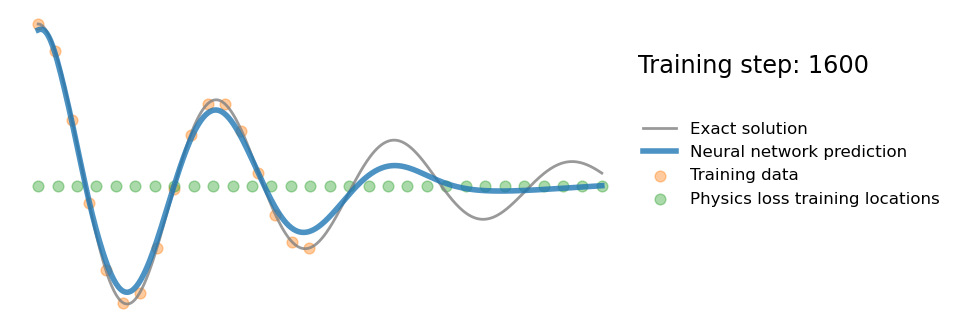

data physics loss tensor(0.0032, grad_fn=<MeanBackward0>) tensor(0.0132, grad_fn=<MulBackward0>)


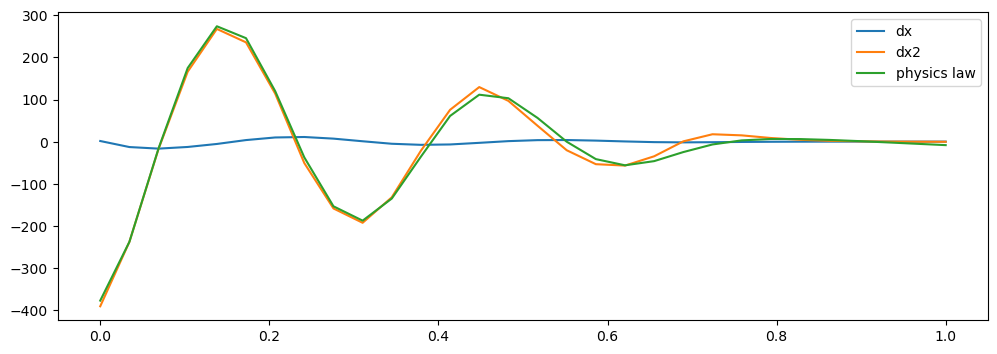

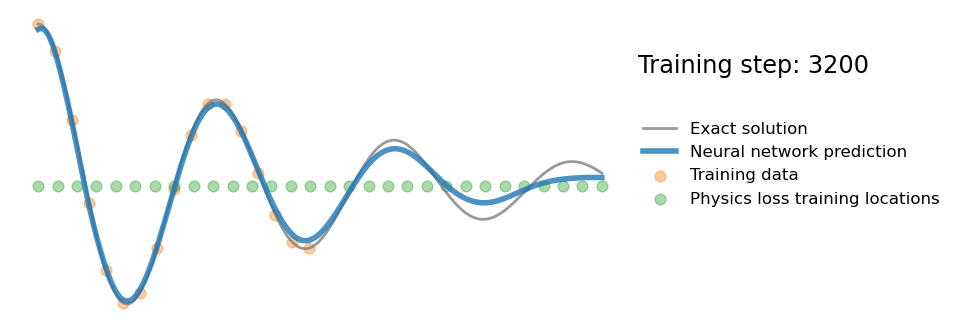

data physics loss tensor(0.0005, grad_fn=<MeanBackward0>) tensor(0.0057, grad_fn=<MulBackward0>)


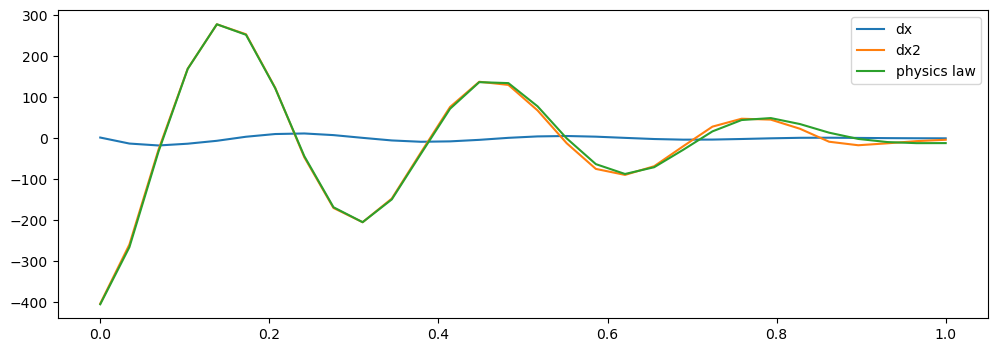

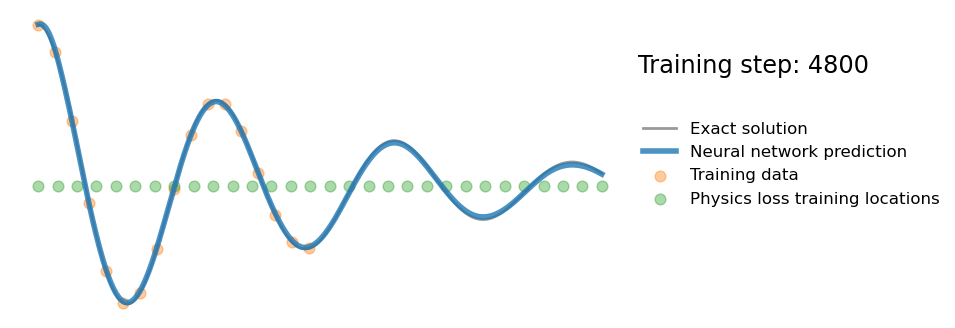

data physics loss tensor(4.7237e-05, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


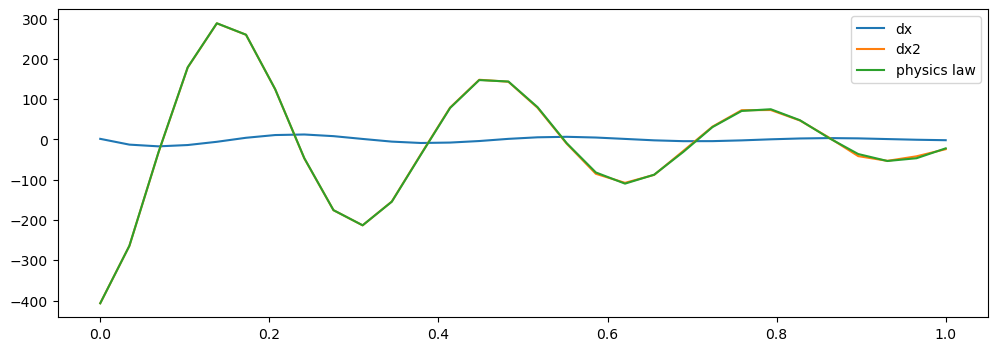

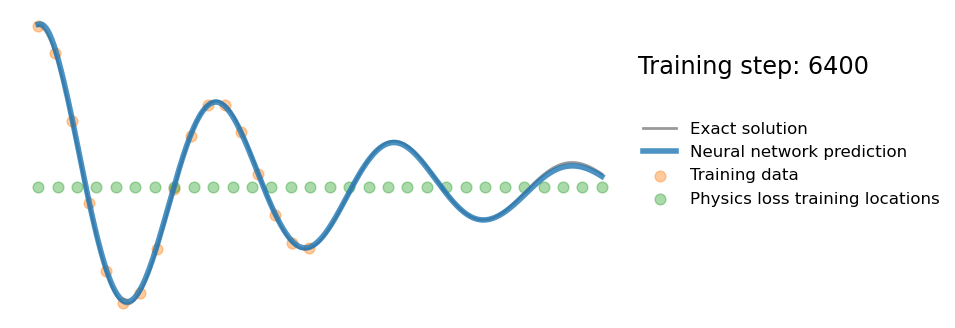

data physics loss tensor(0.0001, grad_fn=<MeanBackward0>) tensor(0.0016, grad_fn=<MulBackward0>)


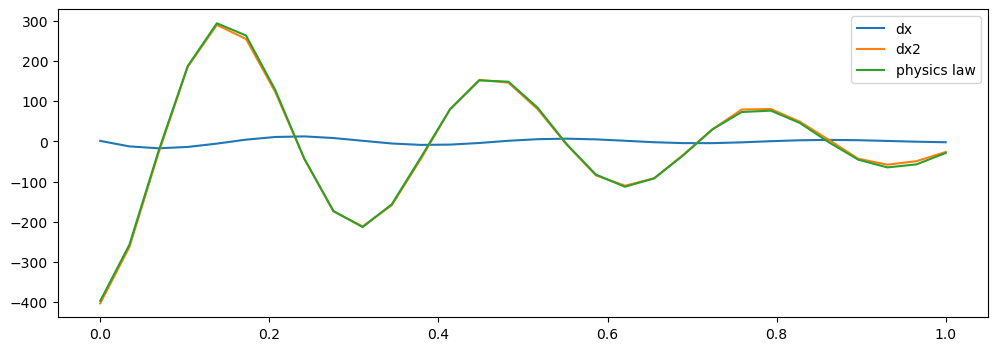

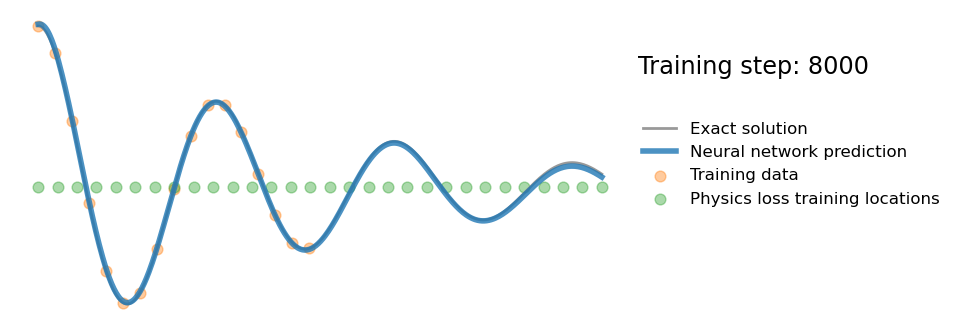

data physics loss tensor(0.0001, grad_fn=<MeanBackward0>) tensor(0.0022, grad_fn=<MulBackward0>)


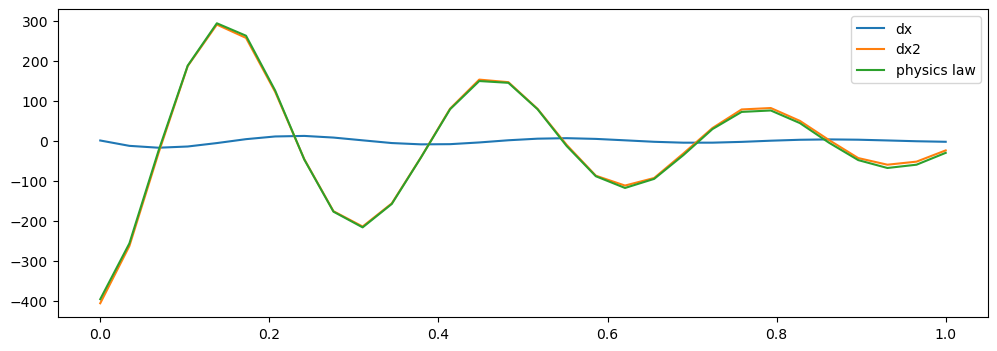

In [8]:
figs=[]
losses = train_oscillator()

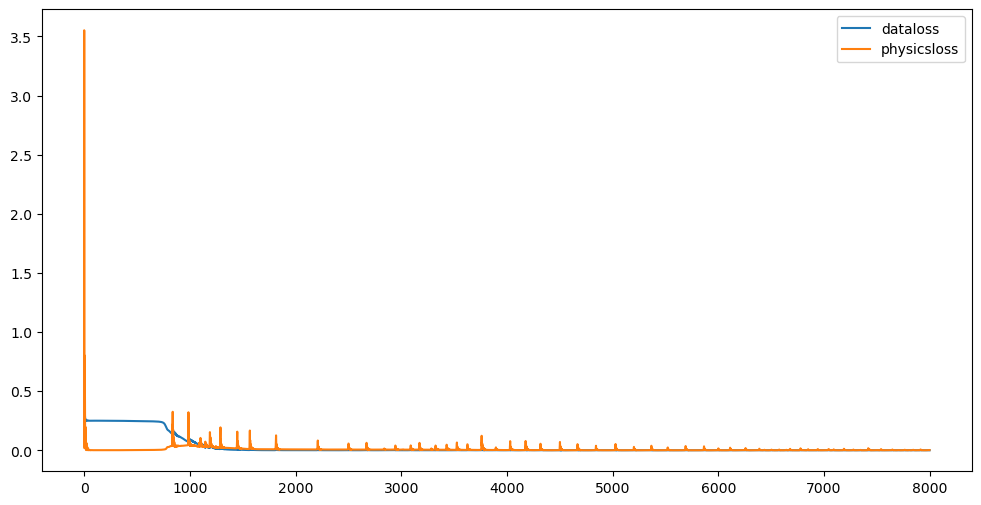

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(losses["dataloss"])), losses["dataloss"], label="dataloss")
plt.plot(range(len(losses["physicsloss"])), losses["physicsloss"], label="physicsloss")
plt.legend()

In [10]:
def driven_oscillator(t, m, k, c, w0, w, F0, x0, v0, phid):
    w0 = np.sqrt(k/m)
    gamma = c/2/m
    
    wprime = np.sqrt(w0**2 - gamma**2)
    print(f"wprime = {wprime}")
    A = F0 / m / np.sqrt((w0**2 - w**2)**2 + 4 * gamma**2 * w**2 )
    
    print(k, m, w**2)
    phi = np.arctan(c * w / (k - m * w**2)) - phid
    phih = np.arctan(wprime * (x0 - A * np.cos(phi)) \
        / (v0 + gamma * (x0 - A * np.cos(phi)) - A * w * np.sin(phi) ) )
    
    Ah = (x0 - A * np.cos(phi)) / np.sin(phih)
    
    x = Ah * np.exp(-gamma * t) * np.sin(wprime * t + phih) + A * np.cos(w * t - phi)
    
    return x

wprime = 9.9498743710662
50 0.5 99.00249999999998
torch.Size([14, 1]) torch.Size([14, 1])


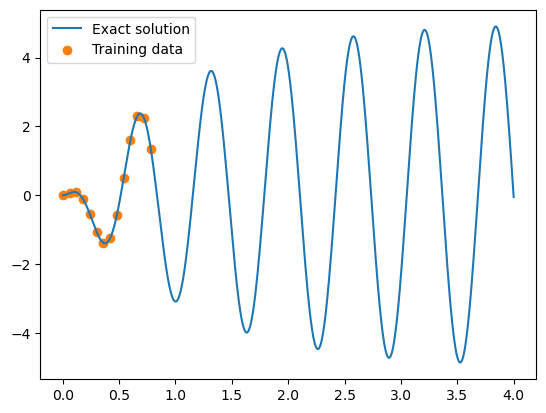

In [11]:
m = 0.5
k = 50
c = 1
w = 9.95
F0 = 50
x0 = 0
v0 = 0
phid = 1

x = torch.linspace(0,4,1000).view(-1,1)
y = driven_oscillator(x, m, k, c, w0, w, F0, x0, v0, phid)
# slice out a small number of points from the LHS of the domain
x_data = x[0:201:15]
y_data = y[0:201:15]
print(x_data.shape, y_data.shape)

plt.figure()
plt.plot(x, y, label="Exact solution")
plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
plt.legend()
plt.show()

In [12]:
def train_driven_oscillator(epochs=500):

    x_physics = torch.linspace(0,4,100).view(-1,1).requires_grad_(True)# sample locations over the problem domain
#     mu, k = 2*d, w0**2

#     torch.manual_seed(2022)
    model = FullyConnected([1, 32, 32, 32, 1], activation=nn.Tanh)
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-2)
    files = []
    losses = dict(dataloss=[], physicsloss=[])
    for i in range(epochs):
        optimizer.zero_grad()

        # compute the "data loss"
        yh = model(x_data)
        dataloss = torch.mean((yh-y_data)**2)# use mean squared error

        # compute the "physics loss"
        yhp = model(x_physics)
        dx  = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]# computes dy/dx
        dx2 = torch.autograd.grad(dx,  x_physics, torch.ones_like(dx),  create_graph=True)[0]# computes d^2y/dx^2
        physics = m * dx2 + c * dx + k*yhp - F0 * torch.cos(w * x_physics + phid)# computes the residual of the 1D harmonic oscillator differential equation
        physicsloss = (1e-4)*torch.mean(physics**2)

        # backpropagate joint loss
        loss = dataloss + physicsloss# add two loss terms together
        loss.backward()
        optimizer.step()
        
        losses["dataloss"].append(dataloss.detach().item())
        losses["physicsloss"].append(physicsloss.detach().item())

        # plot the result as training progresses
#         if (i+1) % 10 == 0: 
        if (i+1) % (epochs//5) == 0: 

            yh = model(x).detach()
            xp = x_physics.detach()

            plot_result(x,y,x_data,y_data,yh, i, xp)
            plt.show()
            fig = plt.figure(figsize=(12, 4))
#             xphysics_plot = x_physics.detach().numpy()
            plt.plot(xp, dx.detach().numpy(), label="dx")
#             plt.plot(xp, dx2.detach().numpy(), label="dx2")
            plt.plot(xp, (m * dx2 + c * dx + k*yhp).detach().numpy(), label="differential left side")
            plt.plot(xp, (F0 * torch.cos(w * x_physics + phid)).detach().numpy(), label="differential right side")
            plt.legend()
            figs.append(fig)
#             print(dx)
#             print(dx2, '\n',  mu*dx + k*yhp)
            print("data physics loss", dataloss, physicsloss)
#             file = "plots/pinn_%.8i.png"%(i+1)
#             plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
#             files.append(file)

#             if (i+1) % 200 == 0: plt.show()
#             else: plt.close("all")

    return losses

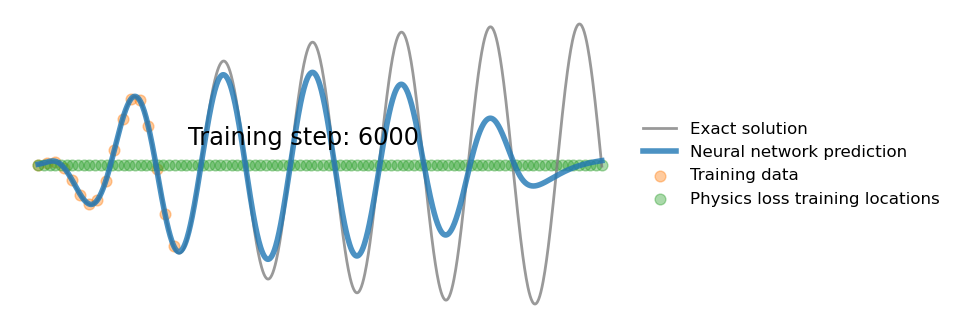

data physics loss tensor(0.0002, grad_fn=<MeanBackward0>) tensor(0.0713, grad_fn=<MulBackward0>)


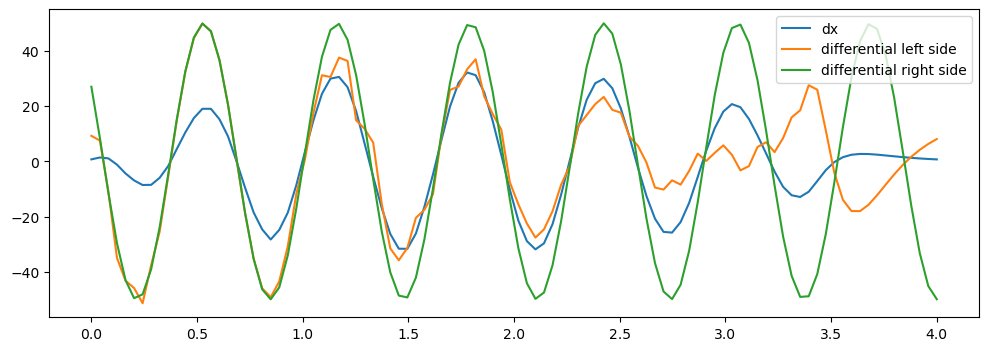

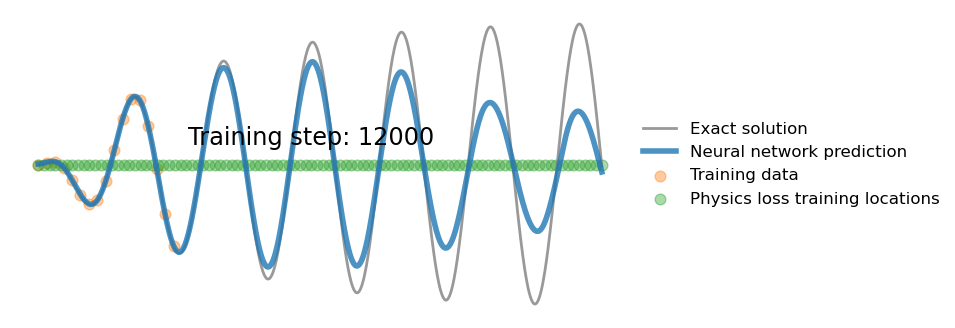

data physics loss tensor(0.0005, grad_fn=<MeanBackward0>) tensor(0.0360, grad_fn=<MulBackward0>)


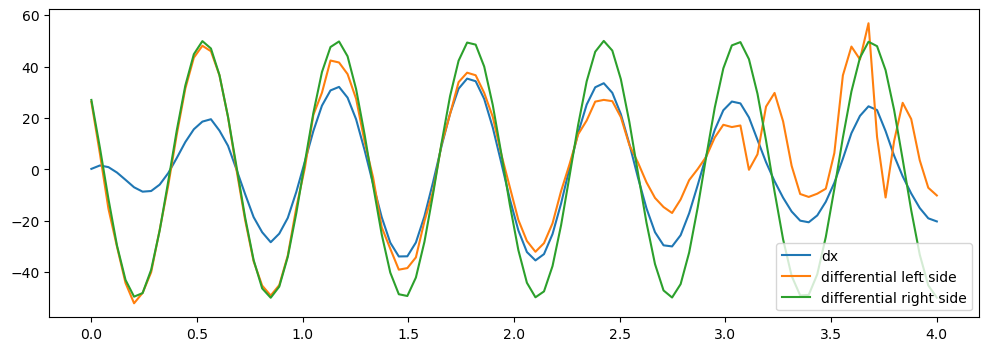

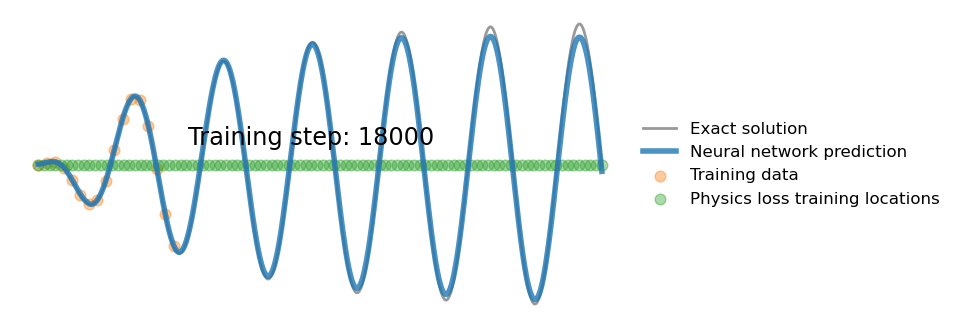

data physics loss tensor(0.0005, grad_fn=<MeanBackward0>) tensor(0.0027, grad_fn=<MulBackward0>)


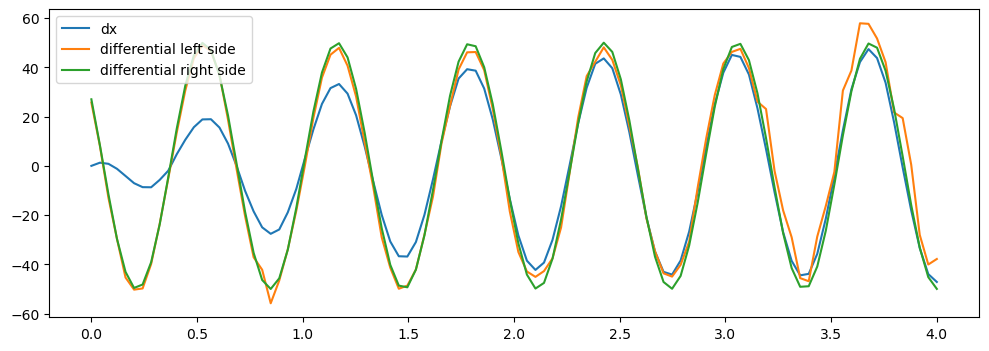

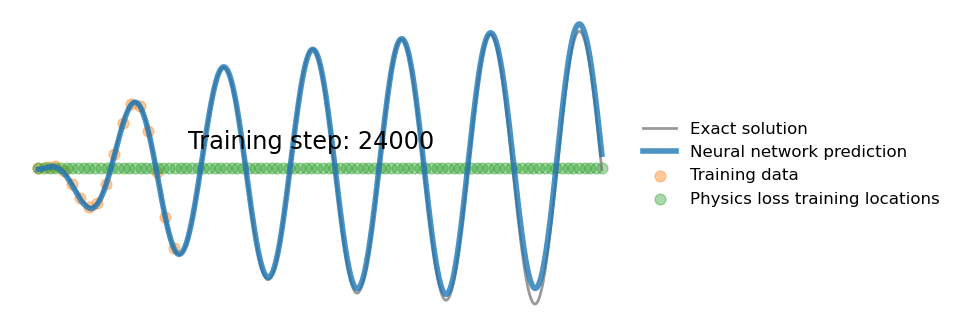

data physics loss tensor(0.0015, grad_fn=<MeanBackward0>) tensor(0.0172, grad_fn=<MulBackward0>)


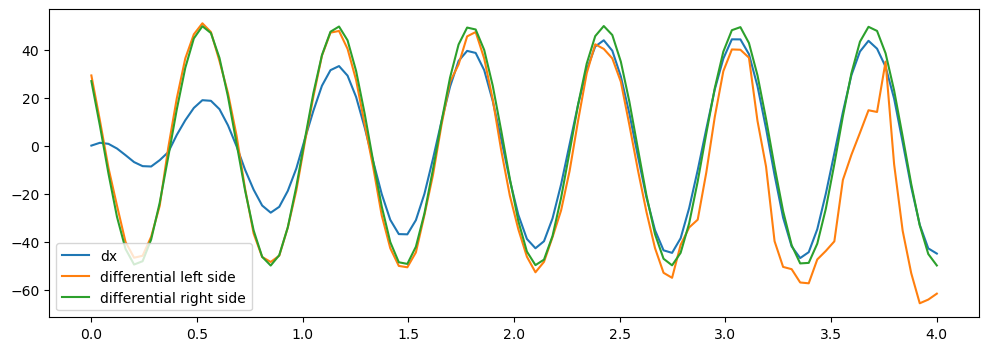

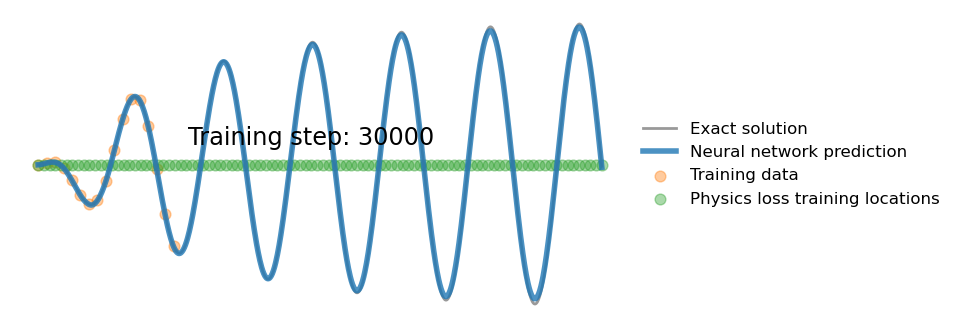

data physics loss tensor(4.8743e-05, grad_fn=<MeanBackward0>) tensor(0.0003, grad_fn=<MulBackward0>)


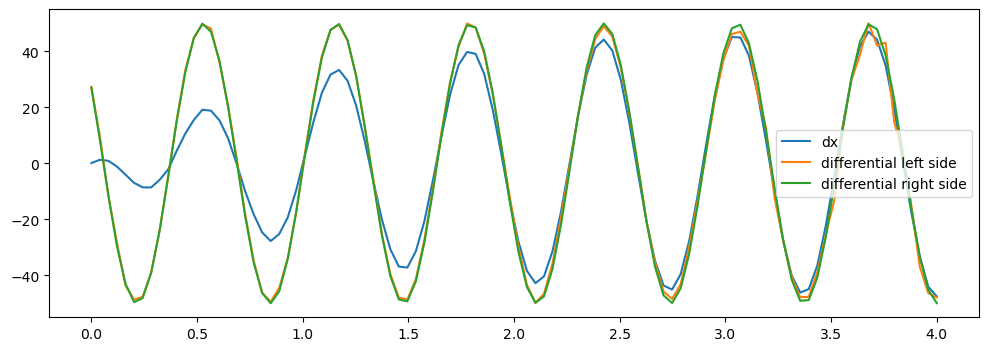

In [13]:
figs=[]
epochs=30000
losses = train_driven_oscillator(epochs)

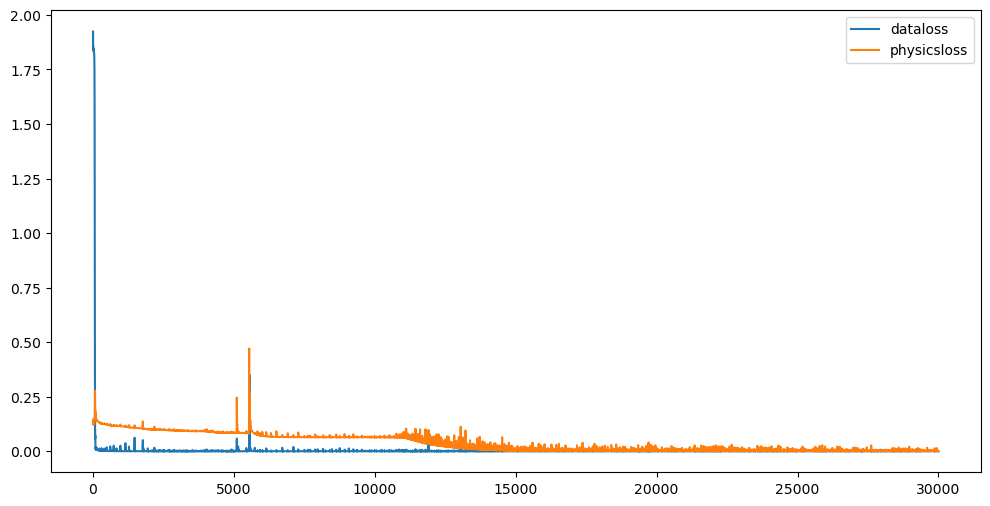

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(losses["dataloss"])), losses["dataloss"], label="dataloss")
plt.plot(range(len(losses["physicsloss"])), losses["physicsloss"], label="physicsloss")
plt.legend()